In this notebook I perform text classification of NIPS papers using LDA. 

## Importing libraries

In [1]:
import os.path
import re
import tarfile
import io
import smart_open
import pandas as pd

## Loading data

In [2]:

def extract_documents():
    fname = r'C:\Users\anupa\Downloads\nips12raw_str602.tgz'

    with tarfile.open(fname, mode='r:gz') as tar:
        # Ignore directory entries, as well as files like README, etc.
        files = [
            m for m in tar.getmembers()
            if m.isfile() and re.search(r'nipstxt/nips\d+/\d+\.txt', m.name)
        ]
        for member in sorted(files, key=lambda x: x.name):
            member_bytes = tar.extractfile(member).read()
            yield member_bytes.decode('utf-8', errors='replace')

docs = list(extract_documents())

In [ ]:
print(len(docs))
print(docs[0])

## Data preparation

In [4]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [5]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [6]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [7]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [8]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [9]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 8644
Number of documents: 1740


## Finding number of topics

In [29]:
model_list = list()
coherence_score = list()
for i in range(2,16,2):
    model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=i,
    passes=passes,
    eval_every=eval_every
)
    coherencemodel = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
    coherence_score.append(coherencemodel.get_coherence())
    model_list.append(model)
    

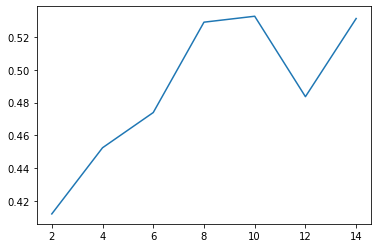

In [32]:
import matplotlib.pyplot as plt
plt.plot(list(range(2,16,2)), coherence_score)
plt.show()

## Training model

In [23]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [25]:
coherencemodel = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
coherencemodel.get_coherence()


0.5539218874780073

In [33]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)




Average topic coherence: -1.7184.


## Visualizing topics

In [36]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
lda_display = pyLDAvis.gensim.prepare(model, corpus, 
                         dictionary, sort_topics=False)

C:\Users\anupa\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [37]:
pyLDAvis.display(lda_display)

In [16]:
def get_topic_details(ldamodel, corpus):
    topic_details_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_details_df = topic_details_df.append(pd.Series([topic_num, prop_topic]), ignore_index=True)
    topic_details_df.columns = ['Dominant_Topic', '% Score']
    return topic_details_df

In [20]:
contents = pd.DataFrame({'Original text':docs})
topic_details = pd.concat([get_topic_details(model,
                           corpus), contents], axis=1)
topic_details.head()

,Dominant_Topic,% Score,Original text
0,2.0,0.690645,"[connectivity, versus, entropy, yaser, abu, mo..."
1,5.0,0.534330,"[stochastic, learning, network, and, their, el..."
2,3.0,0.764972,"[learning, on, general, network, amir, atiya, ..."
3,5.0,0.369315,"[an, artificial, neural, network, for, spatio,..."
4,2.0,0.390147,"[on, property, of, network, of, neuron, like, ..."


In [33]:
model.get_document_topics(corpus, minimum_probability=0.0)


In [35]:

for doc in docs[0:1]:
    print(model.get_document_topics(dictionary.doc2bow(doc)))

[(2, 0.05221698), (3, 0.01603265), (5, 0.08900887), (6, 0.705911), (7, 0.1363573)]
